In [1]:
#!pip install umap-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import scipy.integrate as integrate
import umap

from sklearn.linear_model import LinearRegression 
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.cluster import KMeans

from multiprocessing import Pool
from io import StringIO
from scipy.stats import multivariate_normal, norm

np.random.seed(42)

# 1. Подготовка данных.

In [3]:
url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
response = urllib.request.urlopen(url)
data = response.read()  
data = StringIO(data.decode('utf-8'))
covid_df = pd.read_csv(data)

In [4]:
covid_df = pd.read_csv("owid-covid-data.csv")

In [5]:
covid_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [6]:
print(f"Общее число стран: {len(set(covid_df['location'].values))}")

Общее число стран: 238


In [7]:
def get_country_df(df: pd.DataFrame, country) -> pd.DataFrame:
    res = df.loc[df[df['location'] == country].index, ['location', 'date', 'total_cases', 'new_cases']]
    res = res.reset_index(drop=True)
    res = res.set_index('date')
    # remove zeros
    res[res['total_cases'] == 0] = 1
    res[res['new_cases'] == 0] = 1
    
    
    # last day contains None values, so I'll skip it
    return res[:-1]

def get_train_test_split(df: pd.DataFrame, start_index, train):
    df = df[start_index:]
    return df[:train], df[train:] 

def get_day_numbers_from(dates, first_day):
    return np.array([s.astype('timedelta64[D]').astype(int) for s in (pd.DatetimeIndex(dates) - pd.Timestamp(first_day)).values])


Рассмотрим данные полученые, начиная от 3 марта 2020, и разделим на тренировочную и тестовые выборки.

In [8]:
START_INDEX = '2020-03-03'
TRAIN_DAYS = 50
country = 'Russia'

all_df = get_country_df(covid_df, country)
train_df, test_df = get_train_test_split(all_df, START_INDEX, TRAIN_DAYS)


# 2. Анализ данных.

## 2.1. Использование линейной регрессии.

Построим графики целевых переменных.

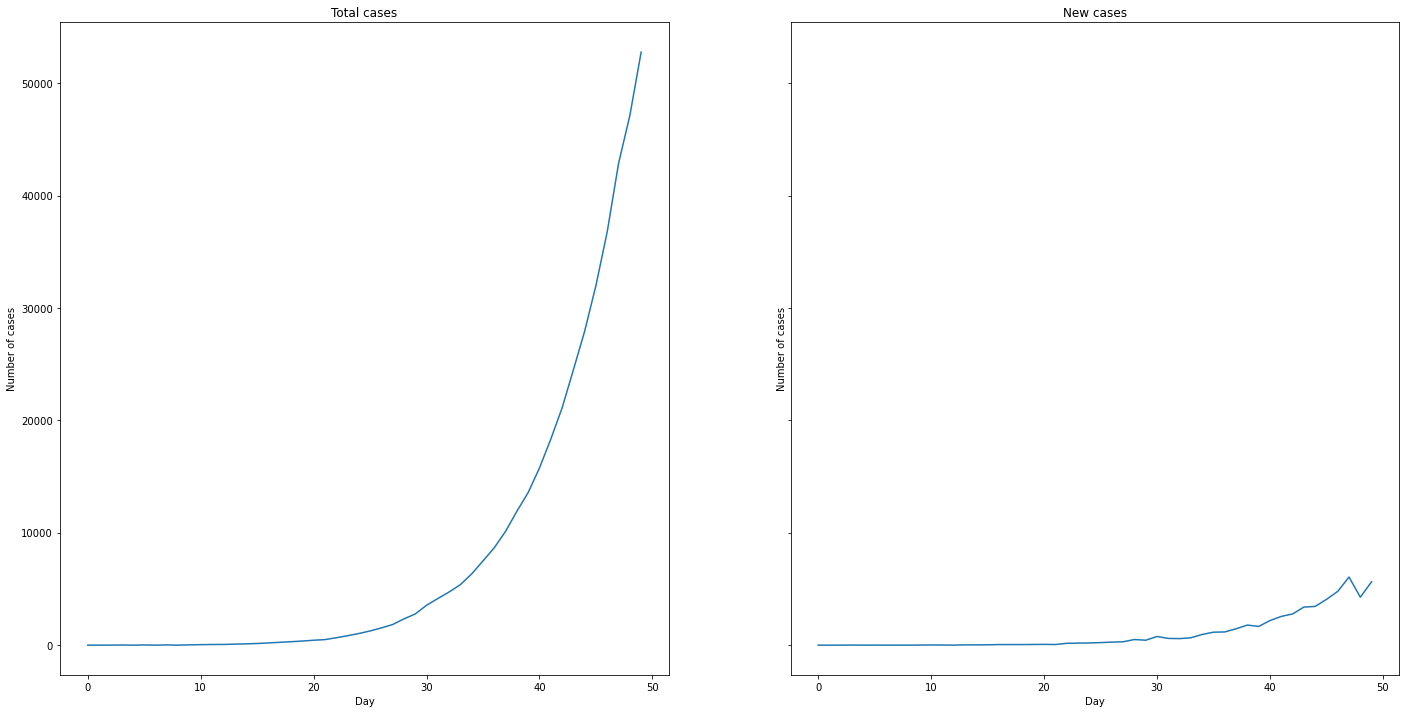

In [9]:
fig, ax = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(24, 12)

ax[0].plot(train_df['total_cases'].values)
ax[0].set_title('Total cases')
ax[1].plot(train_df['new_cases'].values)
ax[1].set_title('New cases')

for t in ax.flat:
    t.set(xlabel='Day', ylabel='Number of cases')

plt.show()

В задании сказано, что рост целевых переменных является экспоненциальным относительно количества прошедших дней. Предположим, что $y = a \cdot e^{kx}$, где $a, k$ - некоторые константы ($a \neq 0$).

Тогда, $$\ln{y} = \ln{a} + k \cdot x.$$

Рассмотрим графики зависимости логарифмов целевых переменных от количества прошедших дней.

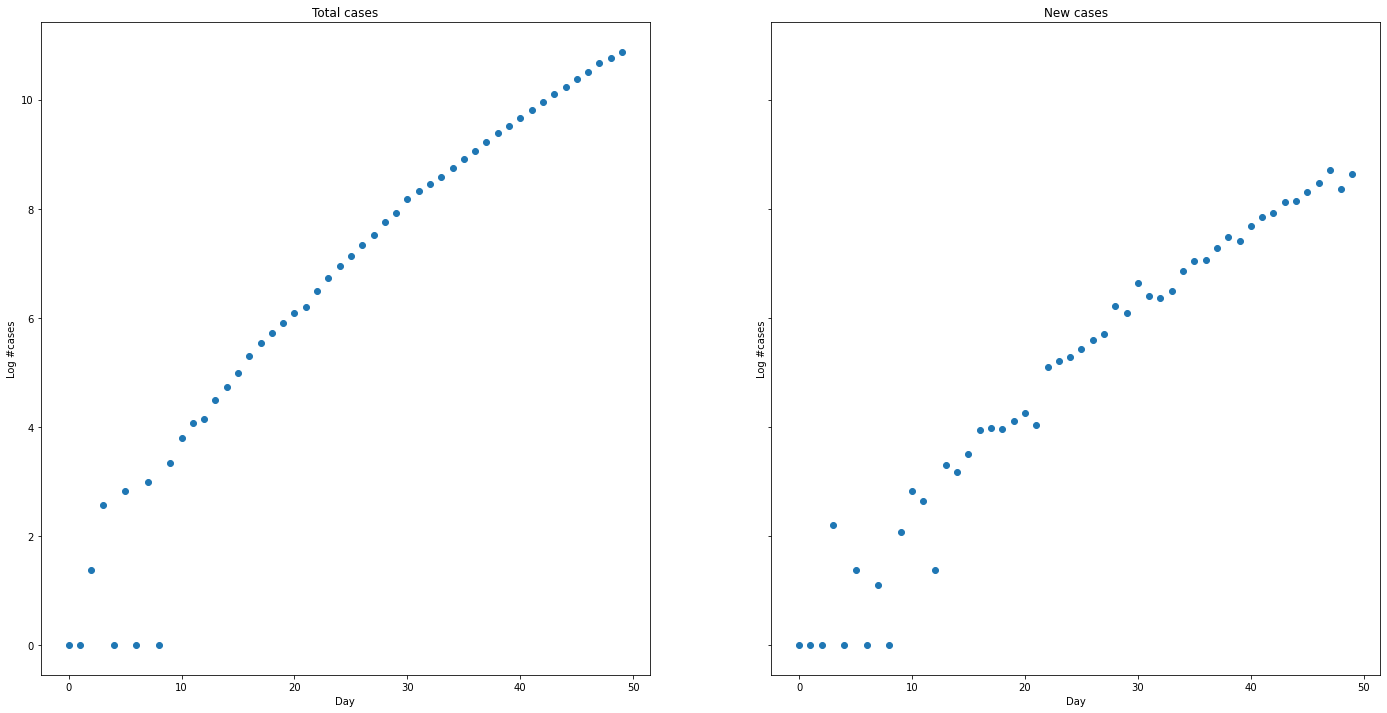

In [10]:
fig, ax = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(24, 12)

ax[0].scatter(x=range(len(train_df)), y=np.log(train_df['total_cases'].values))
ax[0].set_title('Total cases')

ax[1].scatter(x=range(len(train_df)), y=np.log(train_df['new_cases'].values))
ax[1].set_title('New cases')

for t in ax.flat:
    t.set(xlabel='Day', ylabel='Log #cases')

plt.show()

Из графиков выше видно, что логарифмы целевых переменных изменяются линейно.
Подберём параметры соответсвующих прямых.

In [11]:
X_total = get_day_numbers_from(train_df.index, START_INDEX).reshape(-1, 1)
y_total = np.log(train_df.total_cases)
model = LinearRegression()

estimator_total = model.fit(X_total, y_total)

In [12]:
X_new = get_day_numbers_from(train_df.index, START_INDEX).reshape(-1, 1)
y_new = np.log(train_df.new_cases)
model = LinearRegression()

estimator_new = model.fit(X_new, y_new)

In [13]:
print(f"Total: {estimator_total.intercept_:0.2}, {estimator_total.coef_.item():0.2}")
print(f"New: {estimator_new.intercept_:0.2}, {estimator_new.coef_.item():0.2}")

Total: 1.1, 0.22
New: 0.32, 0.19


Построим получившиеся предсказания для целевых переменных на тренировочной выборке.

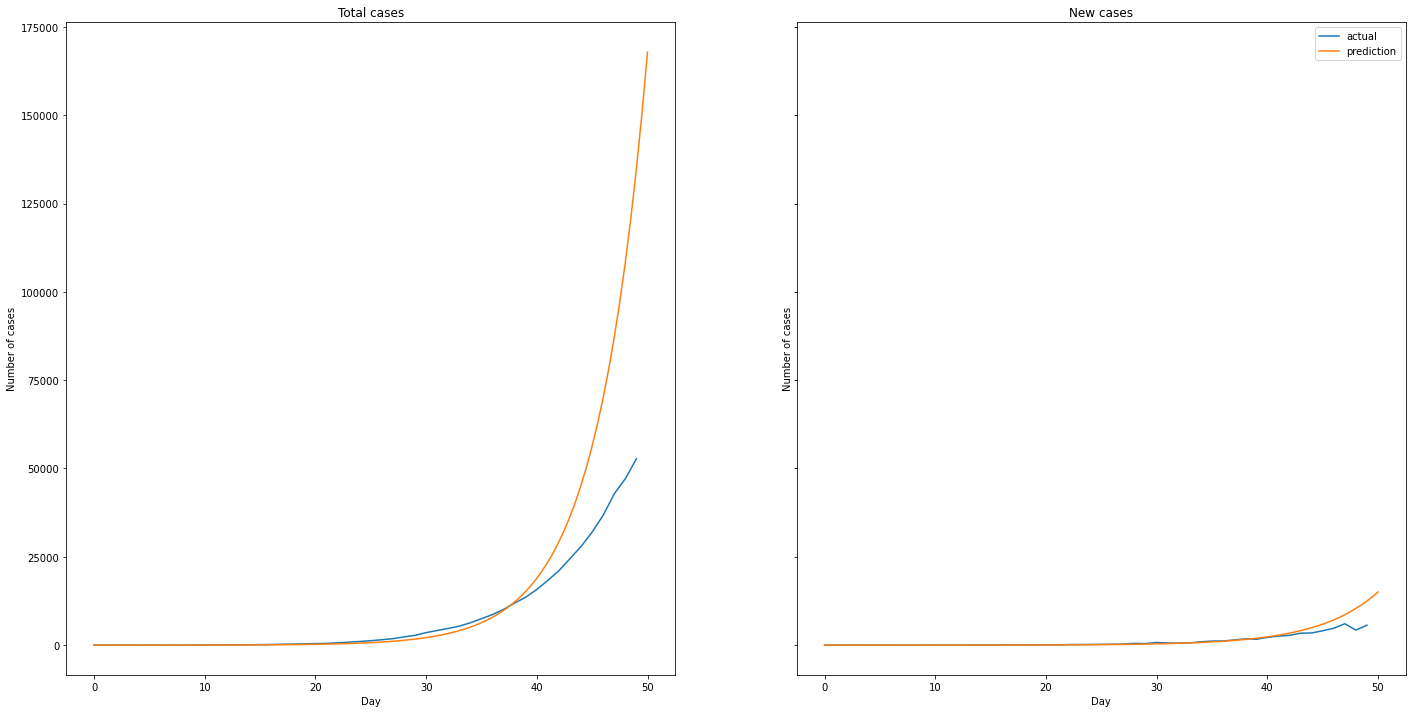

In [14]:
fig, ax = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(24, 12)

X = np.linspace(0, len(train_df), 100).reshape(-1, 1)
ax[0].plot(train_df['total_cases'].values, label='actual')
ax[0].plot(X, np.exp(estimator_total.predict(X)), label='prediction')
ax[0].set_title('Total cases')


ax[1].plot(train_df['new_cases'].values, label='actual')
ax[1].plot(X, np.exp(estimator_new.predict(X)), label='prediction')

ax[1].set_title('New cases')

plt.legend()
for t in ax.flat:
    t.set(xlabel='Day', ylabel='Number of cases')

plt.show()

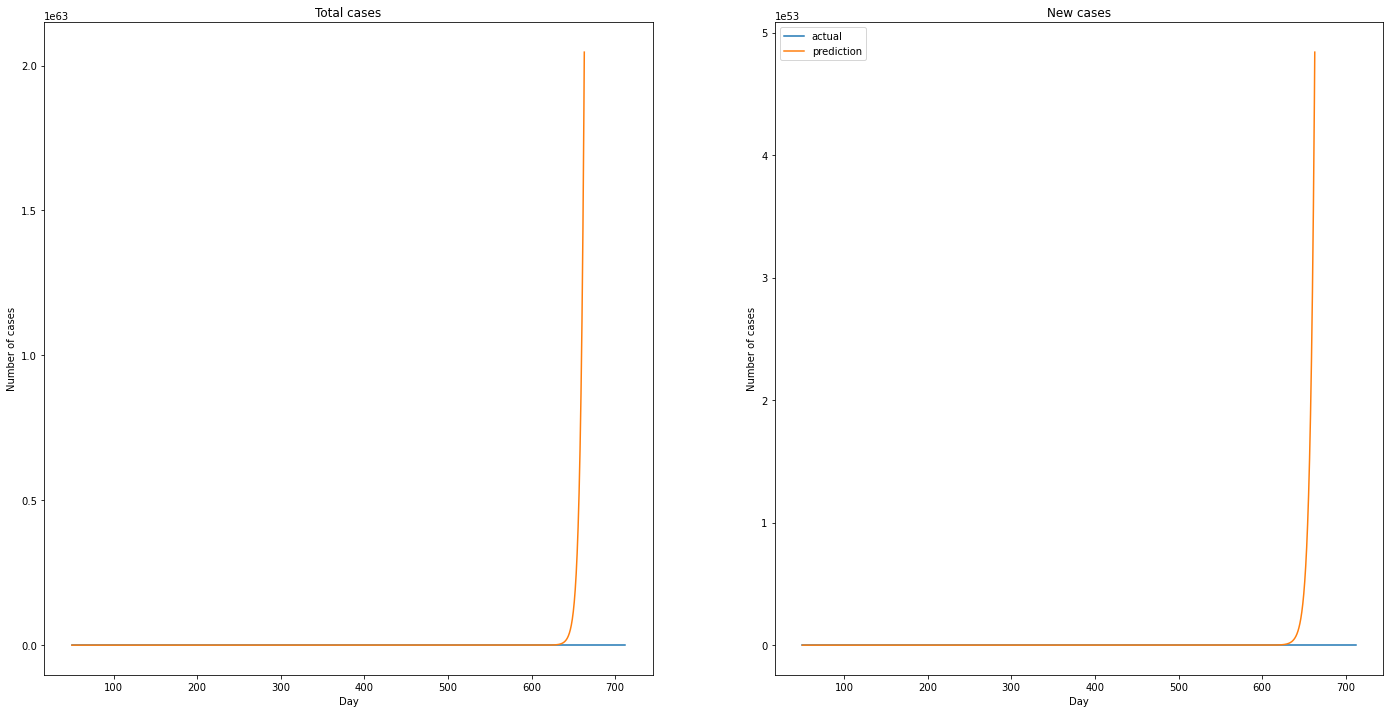

In [15]:
fig, ax = plt.subplots(1, 2, sharey=False)
fig.set_size_inches(24, 12)

X = np.linspace(len(train_df), len(test_df), 4 * len(test_df)).reshape(-1, 1)
ax[0].plot(get_day_numbers_from(test_df.index, START_INDEX), test_df['total_cases'].values, label='actual')
ax[0].plot(X, np.exp(estimator_total.predict(X)), label='prediction')
ax[0].set_title('Total cases')


ax[1].plot(get_day_numbers_from(test_df.index, START_INDEX), test_df['new_cases'].values, label='actual')
ax[1].plot(X, np.exp(estimator_new.predict(X)), label='prediction')

ax[1].set_title('New cases')

plt.legend()
for t in ax.flat:
    t.set(xlabel='Day', ylabel='Number of cases')

plt.show()

## 2.2. Нахождение апостериорного распределения.

Воспользуемся следующими предположениями:

1. Логарифмы целевых переменных линейно зависят от количества прошедших дней с добавлением шума $\epsilon_i$, $i$ - номер дня с начала отсчета. При этом $\epsilon_i \sim N(0, \sigma_{\epsilon})$, и $\epsilon_i$ - независимы в совокупности.
2. Параметры линейной модели имеют многомерное нормальное распределение $N(\vec{\mu_0}, \Sigma_0)$.

Пусть $\vec{\theta}$ - параметры модели, $D$ - наблюдаемые значения целевой переменной, $N$ - размер выборки.

Рассмотрим функцию правдободобия: 
$p(D|\vec{\theta}) = \prod_i p(\epsilon_i)= \prod_i{\frac{1}{\sqrt{2\pi \sigma_{\epsilon}^2}} exp(-\frac{\epsilon_i^2}{2 \sigma_{\epsilon}^2})} =
(\frac{1}{\sqrt{2\pi \sigma_{\epsilon}^2}})^N {exp}(-\frac{\sum_i{\epsilon_i^2}}{2 \sigma_{\epsilon}^2})$.

Найдем значение $\sigma_{\epsilon}$, которое максимизирует функцию правдоподобия.

$$\ln{p(D|\vec{\theta})} = - \frac{N}{2} \ln 2\pi - {N}\ln \sigma_{\epsilon} - \frac{\sum_i{\epsilon_i^2}}{2 \sigma_{\epsilon}^2}.$$

После дифференцирования, приравнивания нулю и применения арифметических операций получаем:

$$ \sigma_{\epsilon} = \sqrt{\frac{\sum_i{\epsilon_i^2}}{N}}. $$

На лекции было показано, что распределение функции правдоподобия и априорное распределение параметров являются при сделанных предположениях явлются сопряженными, т.е. апостериорное распределение параметров также принадлежит семейству многомерных нормальных распределений, и его параметры могут быть расчитаны следующим образом:

$$\mu_N = \Sigma_N (\Sigma_0^{-1}\mu_0 + \frac{1}{\sigma_\epsilon^2} X^T \vec{y}),$$
$$\Sigma_N^{-1} = \Sigma_0^{-1} + \frac{1}{\sigma_\epsilon^2}X X^T.$$


In [16]:
EPS = 1e-17
def add_intercept_w(X):
    return np.hstack((np.ones((X.shape[0], 1)), X)) 

def get_ml_sigma_noise(X, y, theta):
    return np.sqrt(np.sum(np.power(y - theta @ X.T, 2)) / (y.shape[0]) + EPS)

def get_posteriori_params(noise_variance, apriory_params, X, y):
    mu_prior, sigma_prior = apriory_params[0], apriory_params[1]
    sigma_prior_inv = np.linalg.inv(sigma_prior)
    
    sigma_post = np.linalg.inv(sigma_prior_inv + np.power(noise_variance, -2) * X.T @ X)
    mu_post = sigma_post @ (sigma_prior_inv @ mu_prior + np.power(noise_variance, -2) * y.T @ X)
    
    return mu_post, sigma_post

def get_data(target_name):
    X_train = add_intercept_w(get_day_numbers_from(train_df.index, START_INDEX).reshape(-1, 1))
    y_train = np.log(train_df[target_name].values)

    X_test = add_intercept_w(get_day_numbers_from(test_df.index, START_INDEX).reshape(-1, 1))
    y_test = np.log(test_df[target_name].values)
    return X_train, y_train, X_test, y_test

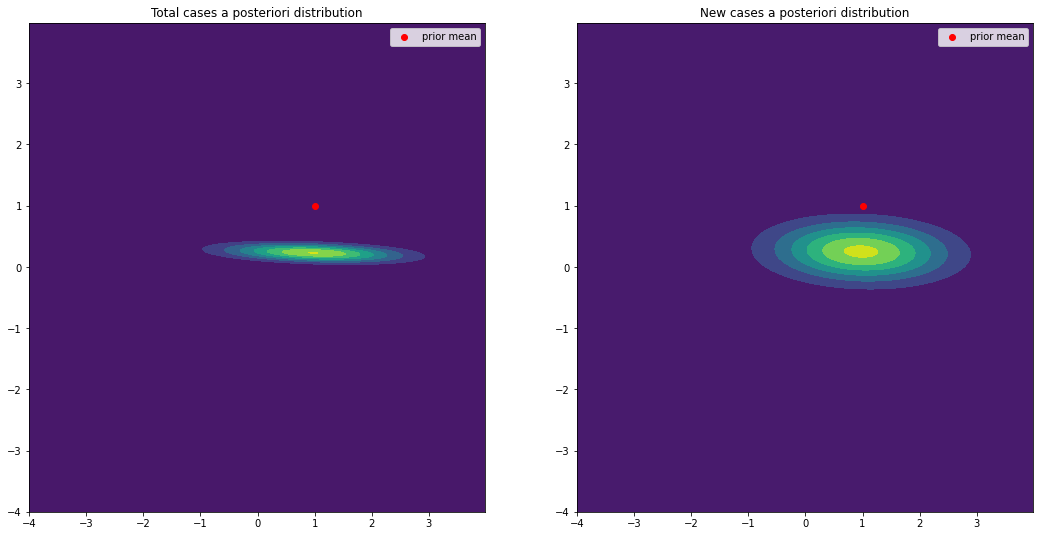

In [17]:
mu_prior = np.array([1, 1])
sigma_prior = np.array([[1, 0], [0, 1]])

x, y = np.mgrid[-4:4:.01, -4:4:.01]

pos = np.dstack((x, y))

X_train, y_train, _, _ = get_data('total_cases')
theta_prior = multivariate_normal(mu_prior, sigma_prior).rvs()
sigma_noise = get_ml_sigma_noise(X_train, y_train, theta_prior)
mu_post, sigma_post = get_posteriori_params(sigma_noise, (mu_prior, sigma_prior), X_train, y_train)
        
rv = multivariate_normal(mu_post, sigma_post)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18, 9)

ax[0].set_title('Total cases a posteriori distribution')
ax[0].contourf(x, y, rv.pdf(pos))
ax[0].scatter(*mu_prior, c='r', label='prior mean')


X_train, y_train, _, _ = get_data('new_cases')
theta_prior = multivariate_normal(mu_prior, sigma_prior).rvs()
sigma_noise = get_ml_sigma_noise(X_train, y_train, theta_prior)
mu_post, sigma_post = get_posteriori_params(sigma_noise, (mu_prior, sigma_prior), X_train, y_train)
        
rv = multivariate_normal(mu_post, sigma_post)

ax[1].set_title('New cases a posteriori distribution')
ax[1].contourf(x, y, rv.pdf(pos))
ax[1].scatter(*mu_prior, c='r', label='prior mean')

ax[0].legend()
ax[1].legend()

plt.show()

## 2.3. Сэмплирование параметров модели.

In [18]:
class BayesModel:
    def __init__(self, mu_prior, sigma_prior):
        self.mu_prior = mu_prior
        self.sigma_prior = sigma_prior
        self.theta_post = None
    
    def fit(self, X, y):
        theta_prior = multivariate_normal(self.mu_prior, self.sigma_prior).rvs()
        sigma_noise = get_ml_sigma_noise(X, y, theta_prior)
        mu_post, sigma_post = get_posteriori_params(sigma_noise, (self.mu_prior, self.sigma_prior), X, y)
        
        self.theta_post = multivariate_normal(mu_post, sigma_post).rvs()
    
    def predict(self, X):
        return self.theta_post @ X.T

In [19]:
def plot_samples(X_train, y_train, X_test, y_test, sample_num, mu_prior, sigma_prior, draw_exp=True):
    y_train_pred_mean = np.zeros(len(y_train))
    y_test_pred_mean = np.zeros(len(y_test))
    
    fig, ax = plt.subplots(2, 2)
    fig.set_size_inches(24, 12)
    
    ax[0][0].set_title('Train')
    ax[1][0].set_title('Train')
    
    ax[0][1].set_title('Test')
    ax[1][1].set_title('Test')
    
    label = None
    for i in range(sample_num):
        bayes_model = BayesModel(mu_prior, sigma_prior)
        bayes_model.fit(X_train, y_train)
        
        y_train_pred = bayes_model.predict(X_train)
        y_test_pred = bayes_model.predict(X_test)
        
        if i == sample_num - 1:
            label = 'predicted' 
            
            
        y_train_draw_pred = y_train_pred
        y_test_draw_pred = y_test_pred
        if draw_exp:
            y_train_draw_pred = np.exp(y_train_pred)
            y_test_draw_pred = np.exp(y_test_pred)
            
        ax[0][0].scatter(X_train[:, 1:], y_train_draw_pred, marker='1', color='r', label=label)
        ax[0][1].scatter(X_test[:, 1:], y_test_draw_pred, marker='1', color='r', label=label)
        
        y_train_pred_mean += y_train_pred
        y_test_pred_mean += y_test_pred
        

    y_train_pred_mean /= SAMPLE_NUM
    y_test_pred_mean /= SAMPLE_NUM
    
    y_train_pred_mean_draw = y_train_pred_mean
    y_test_pred_mean_draw = y_test_pred_mean
    
    if draw_exp:
        y_train_pred_mean_draw = np.exp(y_train_pred_mean)
        y_test_pred_mean_draw = np.exp(y_test_pred_mean)

    ax[1][0].scatter(X_train[:, 1:], y_train_pred_mean_draw, color='green', label='mean_predicted')
    ax[1][1].scatter(X_test[:, 1:], y_test_pred_mean_draw, color='green', label='mean_predicted')

    
    y_train_draw = y_train
    y_test_draw = y_test
        
    if draw_exp:
        y_train_draw = np.exp(y_train)
        y_test_draw = np.exp(y_test)
        
    ax[0][0].scatter(X_train[:, 1:], y_train_draw, marker='+', label='actual')
    ax[0][1].scatter(X_test[:, 1:], y_test_draw, marker='+', label='actual')
    
    ax[1][0].scatter(X_train[:, 1:], y_train_draw, marker='+', label='actual')
    ax[1][1].scatter(X_test[:, 1:], y_test_draw, marker='+', label='actual')
    
    for t in ax.flat:
        t.set(xlabel='Day', ylabel='Number of cases')
        t.legend()

    plt.show()
    

In [20]:
def plot_target_prediction(target_name, sample_num, mu_prior, sigma_prior, draw_exp=True):
    plot_samples(*get_data(target_name), sample_num, mu_prior, sigma_prior, draw_exp)

In [21]:
SAMPLE_NUM = 20

mu_prior = np.array([0.8, 0.3])
sigma_prior = np.array([[0.1, 0], [0, 0.1]])


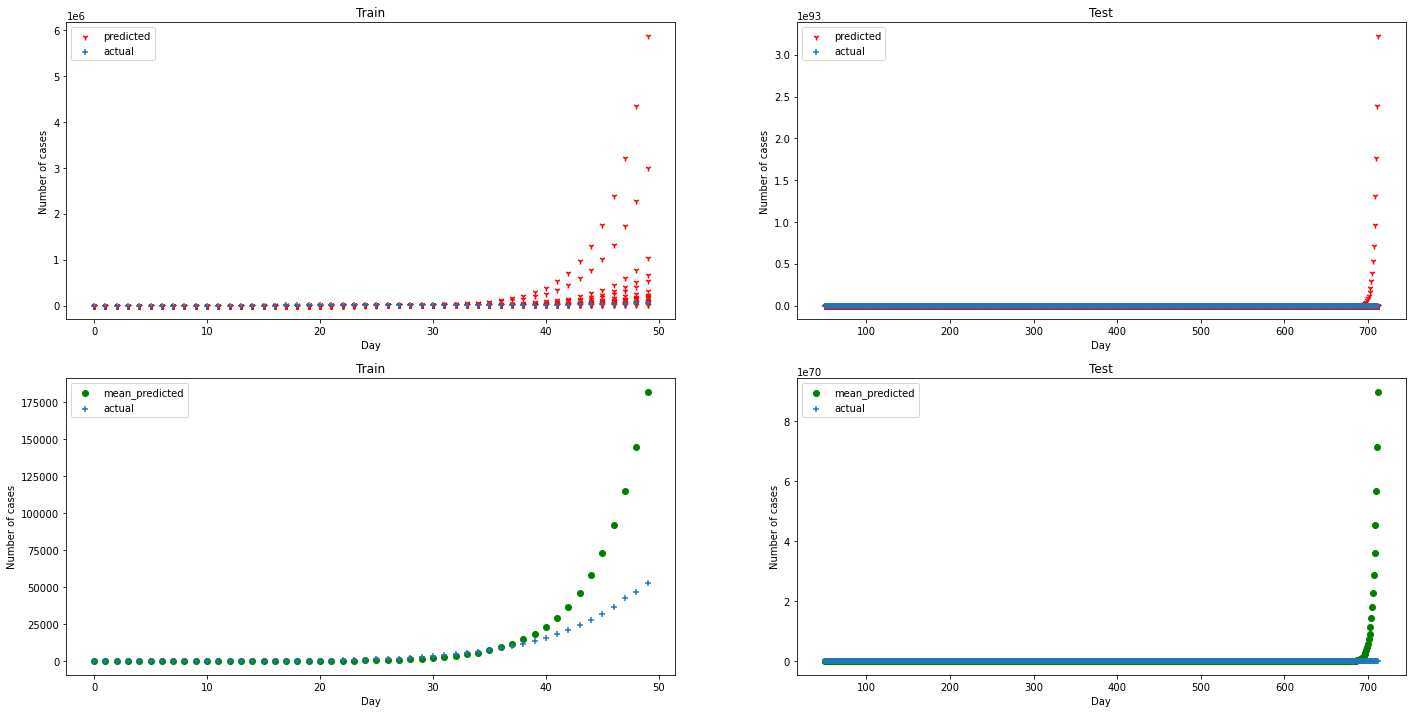

In [22]:
target_name = 'total_cases'
plot_target_prediction(target_name, SAMPLE_NUM, mu_prior, sigma_prior, True)

Ниже представлены графики для числа новых случаев заболевания.

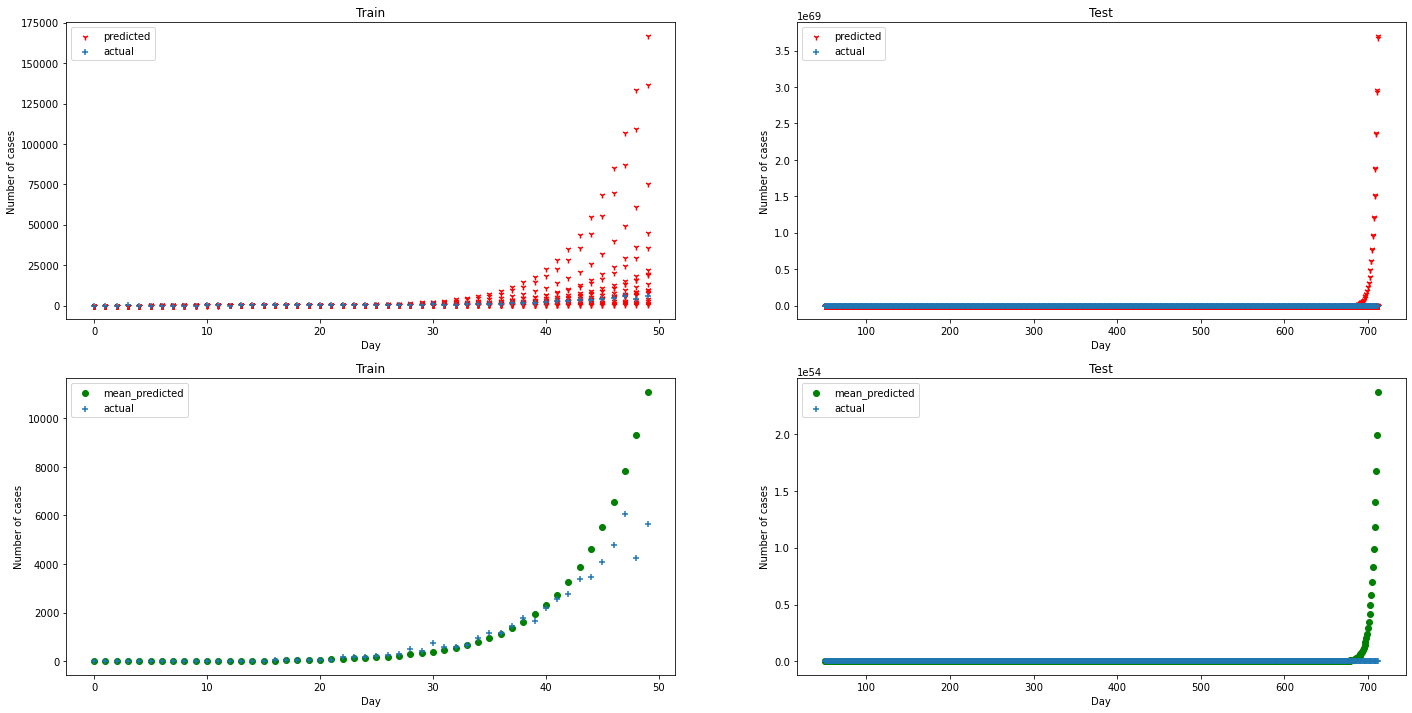

In [23]:
target_name = 'new_cases'
plot_target_prediction(target_name, SAMPLE_NUM, mu_prior, sigma_prior, True)

Построим графики распределений логарифма числа заболевших к 1 мая, 1 июня, 1 сентября соответственно.

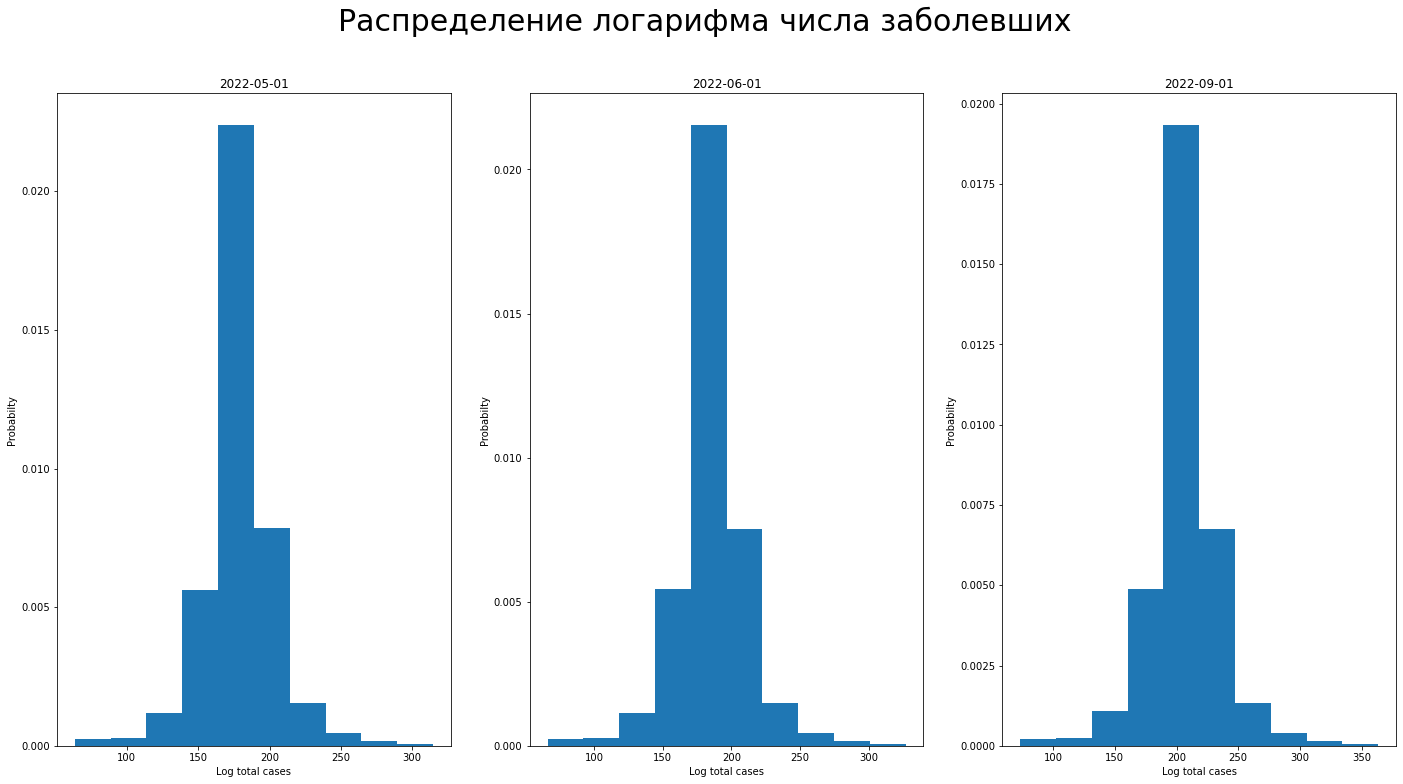

In [24]:
sample_num = 1000
sigma_prior = np.array([[0.05, 0], [0, 0.05]])
mu_prior = np.array([0.9, 0.2])

days = ['2022-05-01', '2022-06-01', '2022-09-01']
X_test = add_intercept_w(get_day_numbers_from(days, START_INDEX).reshape(-1, 1))

X_train, y_train, _, _ = get_data('total_cases')
predictions = []
for i in range(sample_num):
    bayes_model = BayesModel(mu_prior, sigma_prior)
    
    bayes_model.fit(X_train, y_train)
    predictions.append(bayes_model.predict(X_test))

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(24, 12)
fig.suptitle("Распределение логарифма числа заболевших", fontsize=30)
for i in range(len(days)):
    ax[i].hist([t[i] for t in predictions], density=True)
    ax[i].title.set_text(days[i])
    ax[i].set(xlabel='Log total cases', ylabel='Probabilty')
plt.show()

In [25]:
pd.DataFrame({"day": days, "Total cases": np.exp(np.array(predictions).mean(axis=0)) })

,day,Total cases
0,2022-05-01,2.700727e+77
1,2022-06-01,2.871182e+80
2,2022-09-01,2.755301e+89


Таким образом, оценка числа заболевших к 1 сентября 2022 года превышает оценку числа атомов в видимой вселенной.

## 3. Использование другого подхода.

Предположим, что число заболевших зависит от количества прошедших дней следующим оброазом:
$y(z) = \int_{-\infty}^{z} e ^ {at^2 + bt+c},$ где $z$ - номер дня, а $a, b, c$ - некоторые параметры.

Для подбора параметров $a, b, c$ воспользуемся следующими фактами:

1. $ (\int_{s}^{z} f(z))'_z  = f(z)$, для любой непрерывной интегрируемой $f$. 
2. $(f(z))' \approx f(z + 1) - f(z).$ 

Таким образом:
    $$\ln (y(z + 1) - y(z)) \approx az^2 + bz+c.$$
    
То есть, для получения оценок параметров $a, b, c$ может использована линейная регрессия, где в качестве дополнительного признака также взят квадрат от количества прошедших дней.

Для оценки апостериорного распределения параметров $a, b, c$ могут быть применены формулы полученные ранее.

In [26]:
def get_data_gaus_model(train_df, test_df, target_name, start_index):
    X_train = add_intercept_w(get_day_numbers_from(train_df.index, start_index).reshape(-1, 1))
    X_train = np.hstack([X_train, np.power(X_train[:, 1], 2).reshape(-1, 1)])
    X_train = X_train[:-1]
    
    y_train = train_df[target_name].values
    y_train = y_train[1:] - y_train[:-1]
    y_train = np.log(np.where(y_train <= 0, 3, y_train))           
    
    X_test = add_intercept_w(get_day_numbers_from(test_df.index, start_index).reshape(-1, 1))
    X_test = np.hstack([X_test, np.power(X_test[:, 1], 2).reshape(-1, 1)])
    
    y_test = test_df[target_name].values
    return X_train, y_train, X_test, y_test

In [27]:
X_train, y_train, X_test, y_test = get_data_gaus_model(train_df, test_df, 'total_cases', START_INDEX)

In [28]:
def sample_parameters(train_df, test_df, mu_prior, sigma_prior, start_index):
    X_train, y_train, _, _ = get_data_gaus_model(train_df, test_df, 'total_cases', start_index)
    bayes_model = BayesModel(mu_prior, sigma_prior)
    bayes_model.fit(X_train, y_train)
    return bayes_model.theta_post[::-1]

# calculate error function
def gerf(a, b, c, start, end):
    return integrate.quad(lambda x: np.exp(a * x**2 + b * x + c), start, end)[0]

def get_gerf_y(params):
    (a, b, c), x = params
    acc_y = gerf(a, b, c, -float('inf'), x[0])
    
    y = [acc_y]
    
    for i in range(1, len(x)):
        acc_y += gerf(a, b, c, x[i - 1], x[i])
        y.append(acc_y)
    return np.array(y)

def get_prior_params(X_train, y_train):
    lr_model = LinearRegression(fit_intercept=False)
    estimator = lr_model.fit(X_train, y_train)
    mu = estimator.coef_
    sigma = np.array([[0.000001, 0, 0], [0, 0.000001, 0], [0, 0, 0.00000001]])
    return mu, sigma

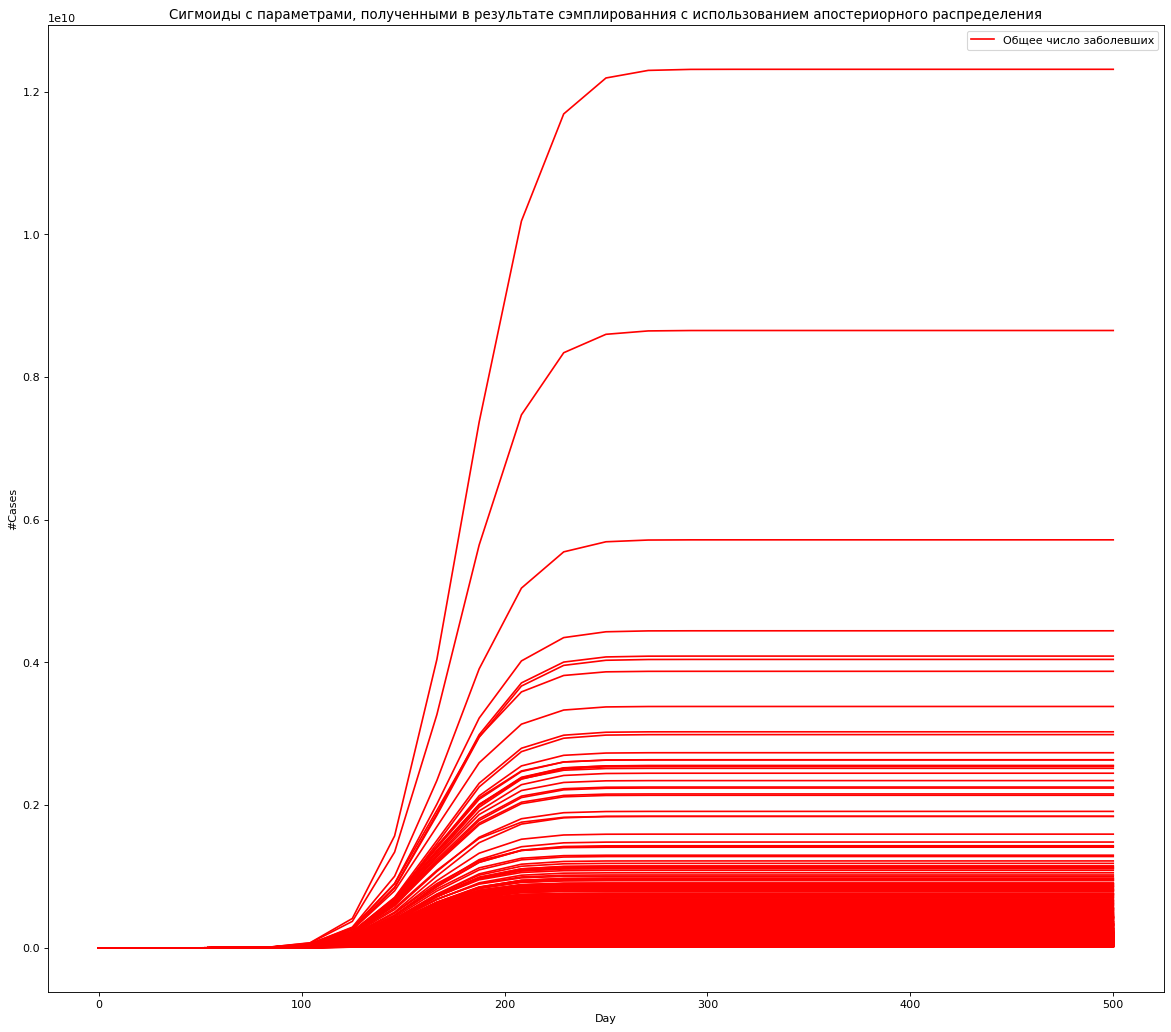

In [29]:
SAMPLES = 1000
mu_prior, sigma_prior = get_prior_params(X_train, y_train)

params = []

for i in range(SAMPLES):
    a, b, c = sample_parameters(train_df, test_df, mu_prior, sigma_prior, START_INDEX)
    params.append((a, b, c))

x = np.linspace(0, 500, 25)
    
with Pool(10) as p:
    y_list = np.array(list(p.map(get_gerf_y, zip(params, [x] * len(params)))))


plt.figure(figsize=(18, 16), dpi=80)
for y in y_list:
    line, = plt.plot(x, y, c='r')    
    
line.set_label('Общее число заболевших')
plt.xlabel('Day') 
plt.ylabel('#Cases') 
plt.title("Сигмоиды с параметрами, полученными в результате сэмплированния с использованием апостериорного распределения")
plt.legend()
plt.show()

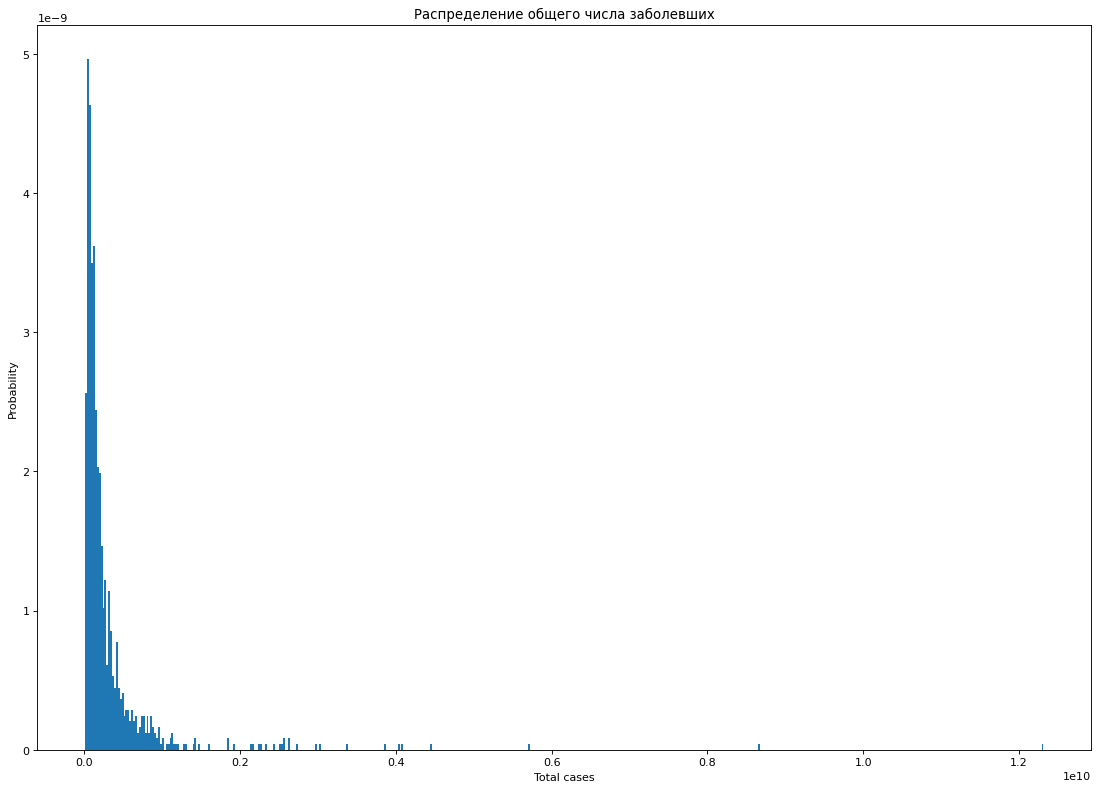

In [30]:
plt.figure(figsize=(17, 12), dpi=80)
plt.hist(y_list[:, -1], bins = 500, density=True)
plt.xlabel('Total cases') 
plt.ylabel('Probability') 
plt.title("Распределение общего числа заболевших")
plt.show()

In [31]:
proc90, proc10 = np.percentile(y_list[:, -1], q=[90, 10])

print(f"Среднее значение общего числа заболевших: {round(y_list[:, -1].mean()):,}")
print(f"90-й процентиль общего числа заболевших:  {round(proc90):,}")
print(f"10-й процентиль общего числа заболевших:   {round(proc10):,}")

Среднее значение общего числа заболевших: 317,779,333
90-й процентиль общего числа заболевших:  661,073,470
10-й процентиль общего числа заболевших:   46,308,903


# 4. Анализ других стран.

Найдем параметры для сигмоид для общего числа заболевших в других странах.

Часть стран не предоставляет данные о числе заболевших.

## 4.1. Нахождение параметров.

In [32]:
FREE_COVID_COUNTRIES = ['Sint Maarten (Dutch part)', 'Northern Cyprus', 'Jersey', 
                        'Niue', 'Turkmenistan', 'Tokelau', 'Guernsey', 'Tuvalu',
                        'Pitcairn','Nauru']

In [33]:
COUNTRIES = list(set(covid_df['location'].values).difference(FREE_COVID_COUNTRIES))


In [34]:
def get_start_index(country):
    df = get_country_df(covid_df, country)
    start_index = df[~df.total_cases.isnull()].index[0]
    return start_index

def get_mean_params(country, samples_num):
    start_index = get_start_index(country)
    X_train, y_train, X_test, y_test = get_data_gaus_model(train_df, test_df, 'total_cases', start_index)
    
    mu_prior, sigma_prior = get_prior_params(X_train, y_train)

    params = []

    for i in range(samples_num):
        a, b, c = sample_parameters(train_df, test_df, mu_prior, sigma_prior, start_index)
        params.append((a, b, c))
    
    return np.mean(params, axis=0)

In [35]:
np.random.seed(42)

params = {}
for country in COUNTRIES:
    params[country] = get_mean_params(country, 10)

Для кластеризации полученных значений параметров воспользуемся методами DBSCAN и UMAP+KMEANS.

## 4.2. Кластеризация с помощью DBSCAN.

In [138]:
from sklearn.preprocessing import StandardScaler # for feature scaling
scaler = StandardScaler()
X = np.array(list(params.values()))
X = scaler.fit_transform(X)

In [148]:
db = DBSCAN(eps=0.2, min_samples=3, metric='euclidean').fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

In [149]:
no_clusters = len(np.unique(db.labels_) )

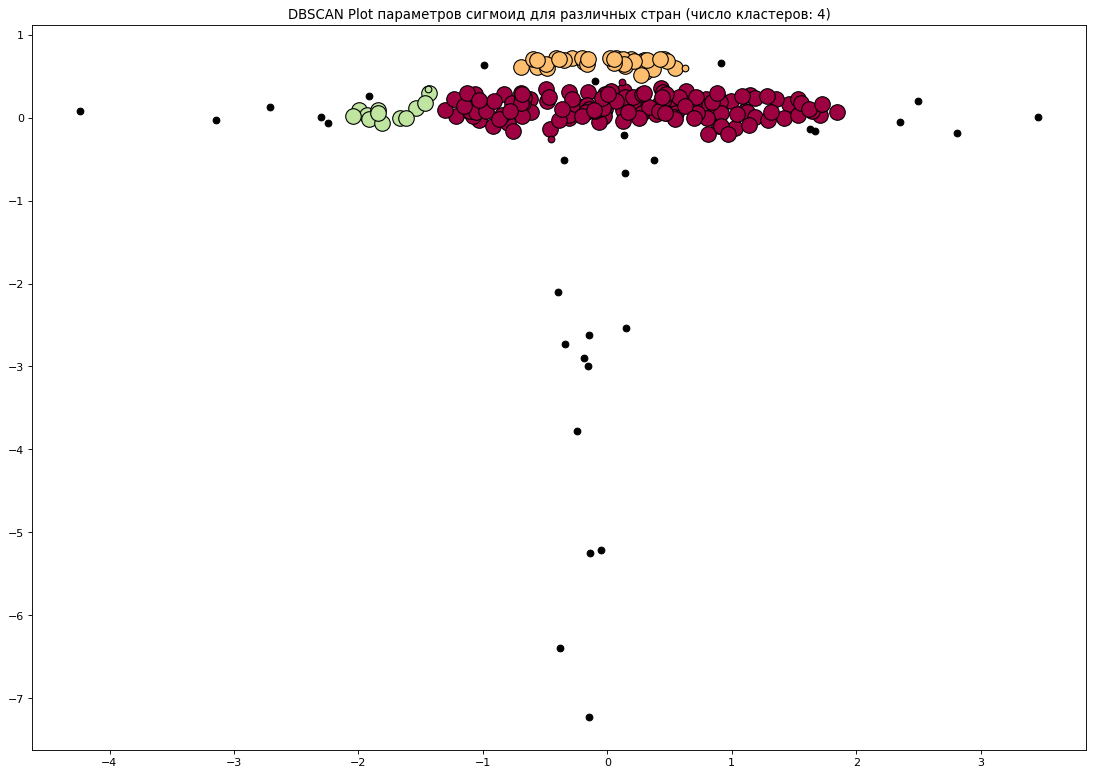

In [150]:
plt.figure(figsize=(17, 12), dpi=80)
unique_labels = set(db.labels_)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = db.labels_ == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"DBSCAN Plot параметров сигмоид для различных стран (число кластеров: {no_clusters})")
plt.show()

In [151]:
clusters = pd.DataFrame({'country': COUNTRIES, 'cluster': db.labels_})
for i, cluster in enumerate(clusters.groupby('cluster')['country'].apply(lambda x: "{%s}" % ', '.join(x)).values):
    print(f"Cluster #{i}:")
    print(cluster)
    print('-----------------------')

Cluster #0:
{Canada, Lesotho, Burundi, El Salvador, Mozambique, Africa, Samoa, United Arab Emirates, Palau, Sao Tome and Principe, Panama, Falkland Islands, Wallis and Futuna, Liechtenstein, Saint Helena, Solomon Islands, Guinea-Bissau, Bonaire Sint Eustatius and Saba, Bermuda, Tonga, Vanuatu, Comoros, Iceland, Laos, Marshall Islands, Kiribati, Micronesia (country), Uruguay, Cook Islands, Tajikistan}
-----------------------
Cluster #1:
{Madagascar, Togo, Botswana, Oman, Yemen, Gabon, Liberia, Afghanistan, Denmark, Benin, Rwanda, Bolivia, Haiti, Fiji, Norway, Greece, Kyrgyzstan, Maldives, Portugal, British Virgin Islands, Bulgaria, Andorra, Cameroon, Kazakhstan, Namibia, Estonia, Dominican Republic, Gibraltar, South Africa, Grenada, Sierra Leone, Argentina, Turkey, Suriname, Ukraine, Honduras, Tunisia, Guatemala, Curacao, Montserrat, Chile, Mongolia, Saint Lucia, Bhutan, Israel, Czechia, Barbados, Peru, Kuwait, Cayman Islands, Latvia, Egypt, Papua New Guinea, Ecuador, Slovenia, Gambia, 

## 4.3. Кластеризация с помощью UMAP + KMEANS.

In [40]:
n_clusters = 14


In [41]:
umap_model = umap.UMAP(random_state=42)
embed_2d = umap_model.fit_transform(X)

In [42]:
kmeans = KMeans(n_clusters=n_clusters)
est = kmeans.fit(X=embed_2d)

In [43]:
clusters = pd.DataFrame({'country': COUNTRIES, 'cluster': kmeans.labels_})
for i, cluster in enumerate(clusters.groupby('cluster')['country'].apply(lambda x: "{%s}" % ', '.join(x)).values):
    print(f"Cluster #{i}:")
    print(cluster)
    print('-----------------------')

Cluster #0:
{Botswana, Yemen, British Virgin Islands, Lesotho, Burundi, Sierra Leone, Sao Tome and Principe, Myanmar, Saint Pierre and Miquelon, Falkland Islands, Wallis and Futuna, Turks and Caicos Islands, Saint Helena, Solomon Islands, Anguilla, Bonaire Sint Eustatius and Saba, South Sudan, Comoros, Malawi, Marshall Islands, Tajikistan}
-----------------------
Cluster #1:
{Togo, Cameroon, South Africa, Bhutan, Peru, Slovenia, Vatican, Bosnia and Herzegovina, Serbia, Slovakia, Colombia, Costa Rica, Palestine}
-----------------------
Cluster #2:
{Gabon, Rwanda, Namibia, Suriname, Guatemala, Curacao, Saint Lucia, Ghana, Eswatini, Saint Vincent and the Grenadines, Mauritania, Sudan, Venezuela, Trinidad and Tobago, Kosovo}
-----------------------
Cluster #3:
{Liberia, Benin, Kyrgyzstan, Mauritius, Montserrat, Barbados, Gambia, Tanzania, Samoa, Somalia, Greenland, Djibouti, Montenegro, Bahamas, Zambia}
-----------------------
Cluster #4:
{Denmark, Norway, Greece, Estonia, Georgia, Belarus

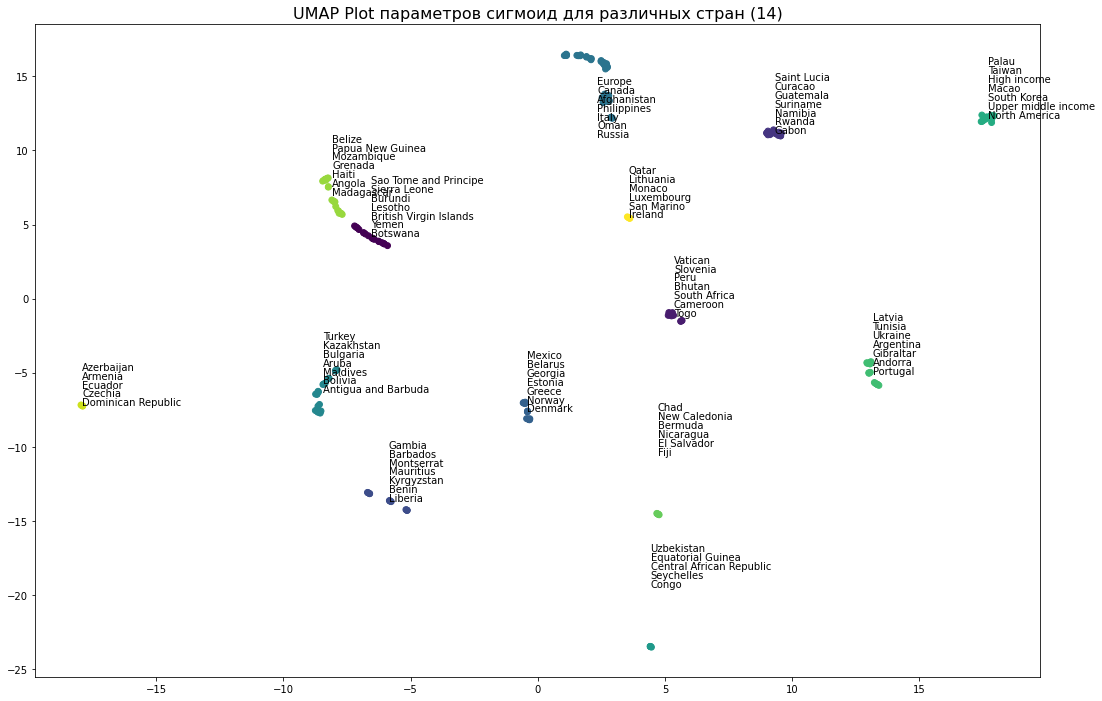

In [48]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 12)
ax.scatter(embed_2d[:,0], embed_2d[:,1], s=35, c=kmeans.labels_)
ax.set_title(f'UMAP Plot параметров сигмоид для различных стран (число кластеров: {n_clusters})',size=16)

n_clusters = len(set(kmeans.labels_))

label_to_ids = {}
for i, label in enumerate(kmeans.labels_):
    if label not in label_to_ids.keys():
        label_to_ids[label] = []
    label_to_ids[label].append(i)

repr_num = 7
for label in set(kmeans.labels_):
    center_x, center_y  = kmeans.cluster_centers_[label]
    
    if np.abs(center_y) > 14:
        center_y -= np.sign(center_y) * 4
    
    for i, idx in enumerate(label_to_ids[label]):
        if i >= min(repr_num, len(label_to_ids[label])):
            break
        country = COUNTRIES[idx]
        ax.annotate(country, (center_x, center_y  + 0.6*i))


# 5. Выводы.

Как я понял, байесовский подход очень сильно зависит от семейства априорных распределений параметров.
Так как в ходе экспериментов я очень сильно ужал это семейство, потому что графики порой "улетали" в бесконечность.

Предсказывать что-то в далеком будущем очень трудно, да и в ближайшем тоже не всегда получается.

По итогам моделирования переболеют все.

Для принятия решения о каких-либо мерах стоит обращаться к мерам, которые не применялись/применялись к болезням со схожей заразностью, а также к опыту других стран. Также можно попробовать смоделировать процесс заражения с помощью SIRS-модели, так как она учитывает выздоровление людей. Стоит помнить, что при построения прогнозов необходимо опираться на достоверные данные. 

Карантин нужно вводить, если рост числа заболевших не удается сдержать при помощи других ограничительных мер (отмена массовых мероприятий, введение ограничений на посещение мест массового скопления людей, маски, перчатки) или при высокой смертности от болезни. 